In [4]:
import cv2
import numpy as np
from PIL import Image
import pandas
import math
from generate_inputs import GenerateInputVector
from generate_inputs import Net
from generate_inputs import device
from generate_inputs import AbsolutePose
from generate_inputs import RelativePose
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
# Load data

traj_num_list = np.arange(1,11)
pose_list, image_list, image1_list, image2_list, rel_pose_list = GenerateInputVector(traj_num_list)

In [7]:
# Loading trained network parameters

device = torch.device("cuda")
net_x = Net()
net_x = net_x.to(device)
net_x = torch.load('./net_x.pyt')
net_y = Net()
net_y = net_y.to(device)
net_y = torch.load('./net_y.pyt')
net_angle = Net()
net_angle = net_angle.to(device)
net_angle = torch.load('./net_angle.pyt')

In [13]:
# Verifying results

import matplotlib.pyplot as plt
rel_pose_pred_array = []
for i in range(len(rel_pose_list)):
    inp = np.stack([image1_list[i], image2_list[i]])
    inp = torch.tensor(np.expand_dims(inp, axis=0)).float().cuda()
    
    rel_x = (net_x(inp).detach().cpu().numpy())[0]
    rel_y = net_y(inp).detach().cpu().numpy()[0]
    rel_angle = net_angle(inp).detach().cpu().numpy()[0]
    rel_pose_pred_array.append(np.array([rel_x, rel_y, rel_angle]))
rel_pose_pred_array = np.squeeze(np.asarray(rel_pose_pred_array))
rel_pose_array = np.asarray(rel_pose_list)

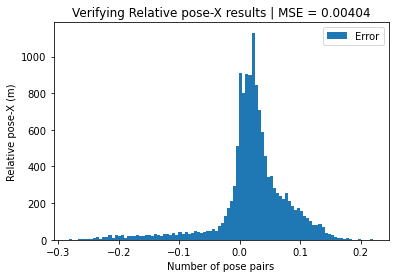

In [14]:
plt.figure()
error_x = rel_pose_array[:,0]-rel_pose_pred_array[:,0]
plt.hist(error_x, label='Error', bins = 100)
# plt.plot(rel_pose_pred_array[:,0], label='Prediction')
plt.xlabel("Number of pose pairs")
plt.ylabel("Relative pose-X (m)")
plt.title("Verifying Relative pose-X results | MSE = " + "{:.5f}".format(np.mean(error_x**2)))
plt.legend()
plt.show()

In [15]:
# Visualizing output

np.warnings.filterwarnings('error', category=np.VisibleDeprecationWarning)    
out_x = [np.asarray([pose_list[0,0]])]
out_y = [np.asarray([pose_list[0,1]])]
out_angle = [np.asarray([pose_list[0,2]])]
pose_list_ver = [pose_list[0]]
rel_pose_act_array = []
rel_pose_pred_array = []
for i in range(len(image_list) - 1):
    inp = np.stack([image_list[i], image_list[i+1]])
    inp = torch.tensor(np.expand_dims(inp, axis=0)).float().cuda()
    
    rel_x = (net_x(inp).detach().cpu().numpy())[0]
    rel_y = net_y(inp).detach().cpu().numpy()[0]
    rel_angle = net_angle(inp).detach().cpu().numpy()[0]
    rel_pose_pred_array.append(np.array([rel_x, rel_y, rel_angle]))
    abs_pose = AbsolutePose(np.array([out_x[i], out_y[i], out_angle[i]]),np.array([rel_x, rel_y, rel_angle]))
    out_x.append(abs_pose[0])
    out_y.append(abs_pose[1])
    out_angle.append(abs_pose[2])
    
    rel_pose_act = RelativePose(pose_list[i], pose_list[i+1])
    rel_pose_act_array.append(rel_pose_act)
    
rel_pose_act_array = np.asarray(rel_pose_act_array)
rel_pose_pred_array = np.asarray(rel_pose_pred_array)
out_x = np.asarray(out_x)
out_y = np.asarray(out_y)
out_angle = np.asarray(out_angle)

plt.figure()
plt.plot(rel_pose_act_array[:,0], label='Actual')
plt.plot(rel_pose_pred_array[:,0], label='Prediction')
plt.xlabel("Time step")
plt.ylabel("Relative pose-X (m)")
plt.title("Verifying Relative pose-X results")
plt.legend()
plt.show()

plt.figure()
plt.plot(rel_pose_act_array[:,1], label='Actual')
plt.plot(rel_pose_pred_array[:,1], label='Prediction')
plt.xlabel("Time step")
plt.ylabel("Relative pose-Y (m)")
plt.title("Verifying Relative pose-Y results")
plt.legend()
plt.show()

plt.figure()
plt.plot(rel_pose_act_array[:,2], label='Actual')
plt.plot(rel_pose_pred_array[:,2], label='Prediction')
plt.xlabel("Time step")
plt.ylabel("Relative pose-Angle (m)")
plt.title("Verifying Relative pose-Angle results")
plt.legend()
plt.show()

IndexError: too many indices for array: array is 0-dimensional, but 1 were indexed